# CREDIT CARD FRAUD DETECTION USING SUPERVISED MACHINE LEARNING AND GENETIC ALGORITHM FEATURE SELECTION​

## Import Necessary Libraries

In [ ]:
!pip install category_encoders
!pip -q install pygad imbalanced-learn xgboost==1.7.6
!pip install deap
!pip install -q catboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pygad
import random

import warnings
warnings.simplefilter("ignore") # Ignore all warnings

from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, f1_score,
    precision_recall_curve, auc, make_scorer, fbeta_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, average_precision_score )
from sklearn.model_selection import train_test_split

# Genetic Algorithm Purposes
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from pathlib import Path
from deap import base, creator, tools
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier

## Load Data

In [ ]:
# Load the training dataset from 'train.csv'
train_df = pd.read_csv('train.csv', index_col='Unnamed: 0')

# Load the test dataset from 'test.csv'
test_df = pd.read_csv('test.csv', index_col='Unnamed: 0')

## Feature Engineering

In [ ]:
# Convert 'trans_date_trans_time' column to datetime objects for both train and test dataframes
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='mixed')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='mixed')

# Extract the 'hour' from the transaction date-time and create a new 'hour' column
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

# Extract the 'month' from the transaction date-time and create a new 'month' column
train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

# Display the first few rows of the modified training dataframe to show the new features
train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
992821,2020-02-09 19:56:03,2242542703101233,fraud_Schumm PLC,shopping_net,2.38,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,...,564,Pensions consultant,1996-04-10,b20aa993023080f7df3445917fc2c529,1360439763,38.238540,-85.331889,0,19,2
833489,2019-12-11 20:10:09,213157767990030,"fraud_Okuneva, Schneider and Rau",shopping_pos,6.53,Tara,Campbell,F,05050 Rogers Well Apt. 439,Rock Springs,...,27971,Music therapist,1984-08-01,699d832d45640a873dc40a78f7197f3f,1355256609,42.402782,-109.452891,0,20,12
517107,2019-08-11 16:59:48,6544734391390261,"fraud_Zboncak, Rowe and Murazik",shopping_net,6.62,John,Myers,M,701 Wilson Divide,Highland,...,23727,Community arts worker,1982-02-08,dfda609e0a608c46084aa260d24fc9b3,1344704388,41.876220,-88.320794,0,16,8
166051,2019-03-29 08:21:13,4635330563105903,"fraud_Bernier, Volkman and Hoeger",misc_net,24.86,Christina,Rose,F,1984 Taylor Island Suite 836,Falls Church,...,116155,Chartered accountant,1983-07-10,09863670cadcdcf7637e5fff4947fe82,1333009273,38.780532,-77.549100,0,8,3
473161,2019-07-27 14:47:05,213141712584544,"fraud_Prosacco, Kreiger and Kovacek",home,25.65,Margaret,Curtis,F,742 Oneill Shore,Florence,...,19685,Fine artist,1984-12-24,8304d76b2d85934b72c39a7624d444bb,1343400425,32.376997,-89.326699,0,14,7


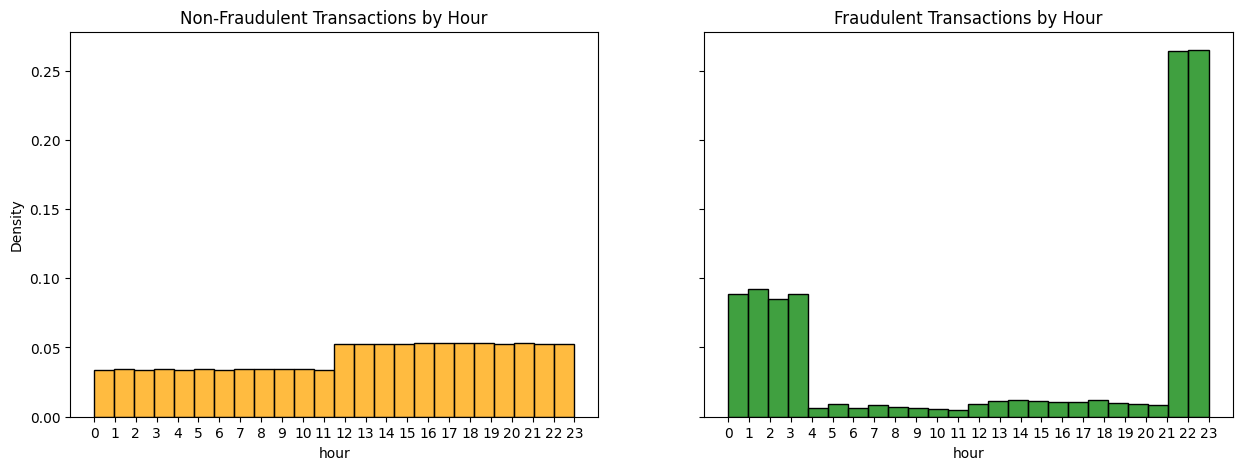

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

# Plotting distribution of non-fraudulent transactions by hour
ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

# Plotting distribution of fraudulent transactions by hour
ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

# Set titles for each subplot
ax1.set_title("Non-Fraudulent Transactions by Hour")
ax2.set_title("Fraudulent Transactions by Hour")

# Set x-axis ticks for each hour of the day (0 to 23)
ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

## Data Preprocessing

In [ ]:
# Calculate the number of unique transactions in the training dataframe
unique_transaction_count = len(train_df['trans_num'].unique())
# Print the total count of unique transaction numbers
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 907672


In [ ]:
# Define a list of columns to be dropped, as they are not useful for the model or are redundant.
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']

# Drop the specified columns from the training dataframe.
train_df = train_df.drop(columns_to_drop, axis=1);

# Drop the specified columns from the test dataframe as well to maintain consistency.
test_df = test_df.drop(columns_to_drop, axis=1);

# Display the first few rows of the modified training dataframe to verify the column removal.
train_df.head(2)

# Clean the 'merchant' column by removing the 'fraud_' prefix for both train and test dataframes.
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

## Down-Sampling and Scaling

In [ ]:
# 1. Remove missing values: Drop rows that contain any missing values from the training DataFrame.
train_df = train_df.dropna()

# 2. Remove outliers in 'amt': Clip extreme values in the 'amt' column to a reasonable range (5 to 1250)
#    instead of removing entire rows, to preserve more data while mitigating outlier impact.
train_df = train_df[(train_df['amt'] >= 5) & (train_df['amt'] <= 1250)]

# 3. Under-sampling (as in paper): Address class imbalance by under-sampling the majority class.
#    The number of non-fraudulent transactions ('No_class') is reduced to match the number of
#    fraudulent transactions ('yes_class').
No_class = train_df[train_df["is_fraud"] == 0]
yes_class = train_df[train_df["is_fraud"] == 1]

# Resample the majority class without replacement to match the minority class size.
No_class = resample(No_class, replace=False, n_samples=len(yes_class), random_state=42)
# Concatenate the balanced classes to form the new down-sampled dataset.
down_samples = pd.concat([yes_class, No_class], axis=0)

# 4. Drop unneeded columns: (Note: Some of these columns may have already been dropped in a previous step.
#    This line ensures they are dropped from the down-sampled dataframe if still present.)
#    These columns are typically dropped because they are identifiers, time-related (after feature extraction),
#    or deemed irrelevant for the model.
columns_to_drop = ['first','unix_time','dob','cc_num','zip','city','street','state','trans_num','trans_date_trans_time']
down_samples = down_samples.drop(columns=columns_to_drop, axis=1, errors='ignore')

# 5. Encode categorical columns: Convert categorical features into numerical representations
#    using Label Encoding, which assigns a unique integer to each category.

# Identify columns with 'object' (string) data types, which are typically categorical.
cat_cols = down_samples.select_dtypes(include=['object']).columns

# Apply Label Encoding to each identified categorical column.
for col in cat_cols:
    le = LabelEncoder()
    down_samples[col] = le.fit_transform(down_samples[col].astype(str))

# 6. Split X and y: Separate the features (X) from the target variable (y).
#    'is_fraud' is the target variable indicating whether a transaction is fraudulent.
X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

# 7. Min-Max Scaling (0–1): Scale numerical features to a common range [0, 1].
#    This helps prevent features with larger values from dominating the learning algorithm.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 8. Train/test split: Divide the dataset into training and testing sets.
#    80% of the data is used for training the model, and 20% for evaluating its performance.
#    stratify=y ensures that the proportion of target variable 'is_fraud' is the same in
#    both training and testing sets, which is crucial for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=65, stratify=y
)

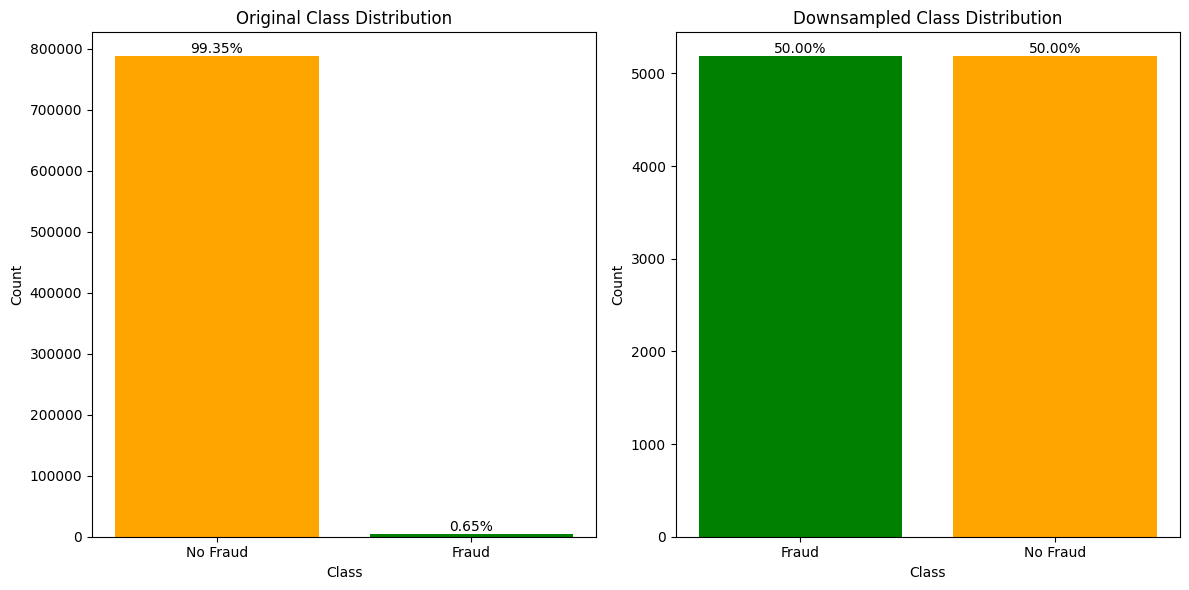

In [ ]:
# Calculate the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Calculate the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class for both original and downsampled data
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Set up the figure and two subplots for visualization
plt.figure(figsize=(12, 6))


# Subplot 1: Original Class Distribution
plt.subplot(1, 2, 1)
# Create a bar plot for the original class counts
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
# Annotate each bar with its percentage value
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])


# Subplot 2: Downsampled Class Distribution
plt.subplot(1, 2, 2)
# Create a bar plot for the downsampled class counts
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
# Annotate each bar with its percentage value
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

# Adjust layout to prevent overlapping titles/labels and ensure all elements are visible
plt.tight_layout()
plt.show()

## Machine Learning Models Training

### Helper function

In [ ]:
# ---------- Helper function: evaluation with plots + threshold tuning ----------
def evaluate_model_with_plots(model, X_test, y_test, name="Model", tune_threshold=True):
    """
    This helper function evaluates a trained classification model and visualizes its performance.
    It calculates key metrics like ROC-AUC, PR-AUC, and Average Precision.
    Optionally, it tunes the classification threshold to find the optimal F1-score.
    Finally, it prints a classification report and displays confusion matrices, ROC curves, and Precision-Recall curves.

    Args:
        model: The trained machine learning classifier with `predict_proba` method.
        X_test: The feature set of the test data.
        y_test: The true labels of the test data.
        name (str): A name for the model, used in titles and legends.
        tune_threshold (bool): If True, tunes the classification threshold for the best F1-score.
                               If False, uses a default threshold of 0.5.
    """
    # 1. Calculate Probabilities and Default Predictions
    #    `predict_proba` returns probabilities for both classes; we're interested in the positive class (1).
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_default = (y_proba >= 0.5).astype(int)


    # 2. Calculate Evaluation Metrics
    #    - ROC-AUC: Area Under the Receiver Operating Characteristic Curve.
    #    - PR-AUC: Area Under the Precision-Recall Curve.
    #    - Average Precision (AP): Summarizes the precision-recall curve as the weighted mean of precisions achieved at each threshold.
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    ap = average_precision_score(y_test, y_proba)

    print(f"\n===== {name} === Grantz===")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"Avg Precision (AP): {ap:.4f}")


    # 3. Threshold Tuning (Optional) for Best F1-score
    #    Iterates through different probability thresholds to find the one that maximizes the F1-score.
    best_thr = 0.5
    best_f1 = f1_score(y_test, y_pred_default)

    if tune_threshold:
        # Explore thresholds from 0.05 to 0.95 with 19 steps
        for thr in np.linspace(0.05, 0.95, 19):
            y_pred_thr = (y_proba >= thr).astype(int)
            f1 = f1_score(y_test, y_pred_thr)
            if f1 > best_f1:
                best_f1 = f1
                best_thr = thr

    print(f"Best threshold (by F1): {best_thr:.2f}")
    # Apply the determined best threshold to make final predictions
    y_pred = (y_proba >= best_thr).astype(int)


    # 4. Classification Report
    #    Provides a summary of precision, recall, f1-score for each class.
    print("Classification report at best threshold:")
    print(classification_report(y_test, y_pred))


    # 5. Confusion Matrix Visualization (Raw Counts)
    #    Shows the number of true positives, true negatives, false positives, and false negatives.
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (raw counts):\n", cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"])
    disp.plot(values_format='d')
    plt.title(f"{name} - Confusion Matrix (thr={best_thr:.2f})")
    plt.show()


    # 6. Normalized Confusion Matrix Visualization
    #    Shows the proportion of true positives, true negatives, false positives, and false negatives, relative to the actual classes.
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=["Not Fraud", "Fraud"])
    disp_norm.plot(values_format='.2f')
    plt.title(f"{name} - Normalized Confusion Matrix (thr={best_thr:.2f})")
    plt.show()


    # 7. ROC Curve Plot
    #    Visualizes the trade-off between true positive rate and false positive rate at various thresholds.
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], '--') # Plot the random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()


    # 8. Precision-Recall Curve Plot
    #    Visualizes the trade-off between precision and recall at various thresholds, especially useful for imbalanced datasets.
    plt.plot(rec, prec, label=f'{name} (PR AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    plt.show()


    # 9. Return Key Metrics
    #    Returns a dictionary containing the calculated evaluation metrics.
    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "avg_precision": ap,
        "best_threshold": best_thr,
        "best_f1": best_f1
    }

### Logistic Regression


===== Logistic Regression === Grantz===
ROC-AUC: 0.8433
PR-AUC:  0.8885
Avg Precision (AP): 0.8886
Best threshold (by F1): 0.55
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1037
           1       0.93      0.75      0.83      1037

    accuracy                           0.85      2074
   macro avg       0.86      0.85      0.85      2074
weighted avg       0.86      0.85      0.85      2074

Confusion matrix (raw counts):
 [[980  57]
 [256 781]]


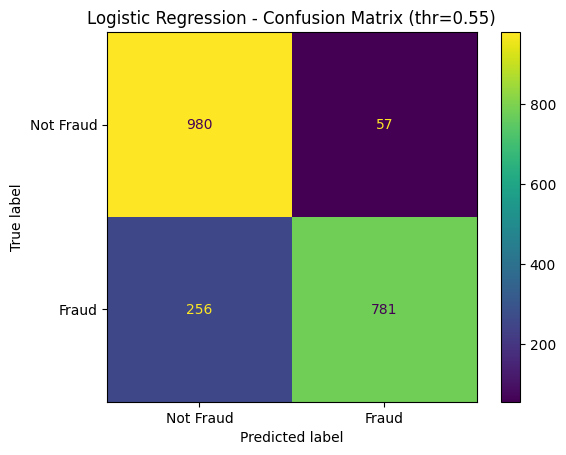

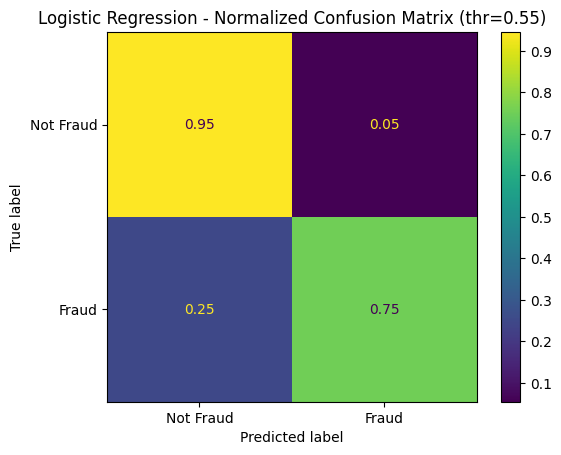

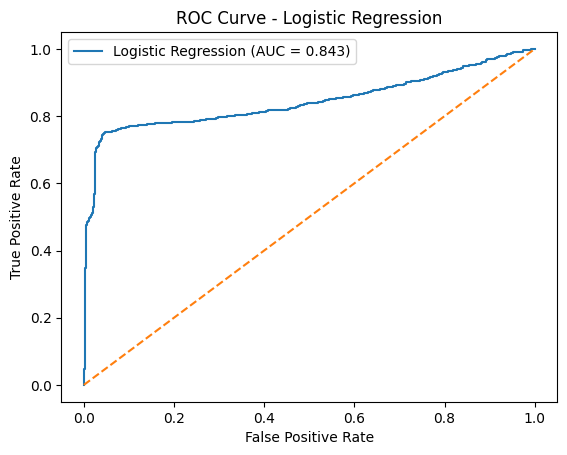

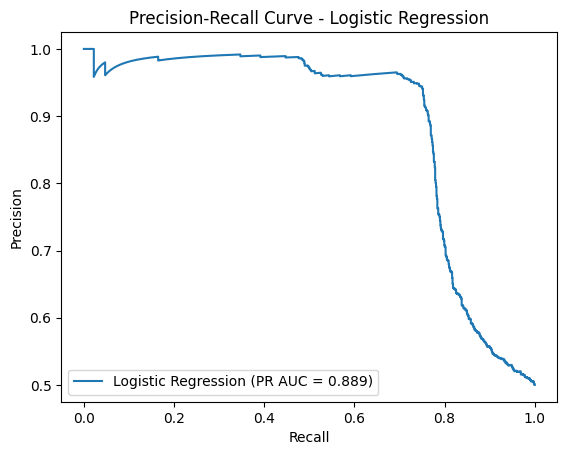

0.8428158148505304


In [ ]:
# Initialize the Logistic Regression model
# max_iter: Maximum number of iterations taken for the solvers to converge.
# class_weight: 'balanced' helps to handle imbalanced datasets by automatically adjusting weights inversely proportional to class frequencies.
# n_jobs: Number of CPU cores to use. -1 means using all available processors.
# random_state: Controls the randomness of the estimator.

LR_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # helpful for fraud / imbalance
    n_jobs=-1,
    random_state=42
)

# Train the Logistic Regression model using the scaled training data
LR_model.fit(X_train, y_train)

# Evaluate the Logistic Regression model using the custom helper function
lr_metrics = evaluate_model_with_plots(
    LR_model, X_test, y_test, name="Logistic Regression"
)

# Calculate and print the accuracy score of the Logistic Regression model on the test set
LR_accuracy = accuracy_score(y_test, LR_model.predict(X_test))
print(LR_accuracy)

### Decision Tree


===== Decision Tree === Grantz===
ROC-AUC: 0.9789
PR-AUC:  0.9829
Avg Precision (AP): 0.9720
Best threshold (by F1): 0.85
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1037
           1       0.98      0.95      0.96      1037

    accuracy                           0.96      2074
   macro avg       0.96      0.96      0.96      2074
weighted avg       0.96      0.96      0.96      2074

Confusion matrix (raw counts):
 [[1016   21]
 [  57  980]]


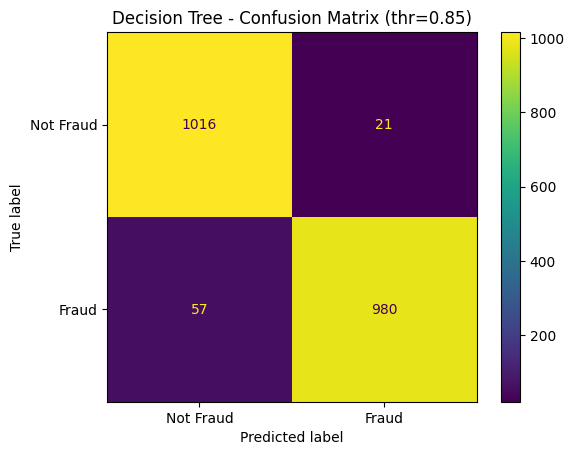

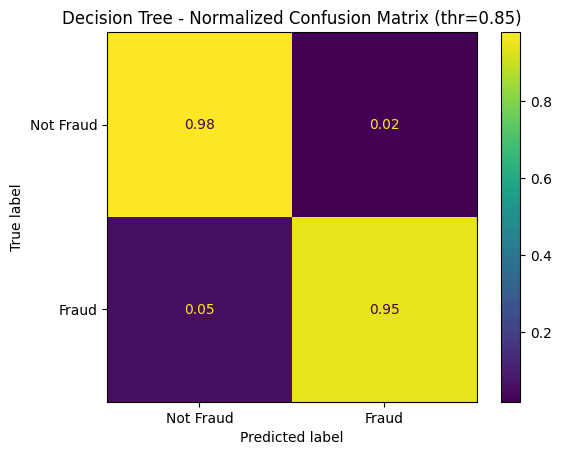

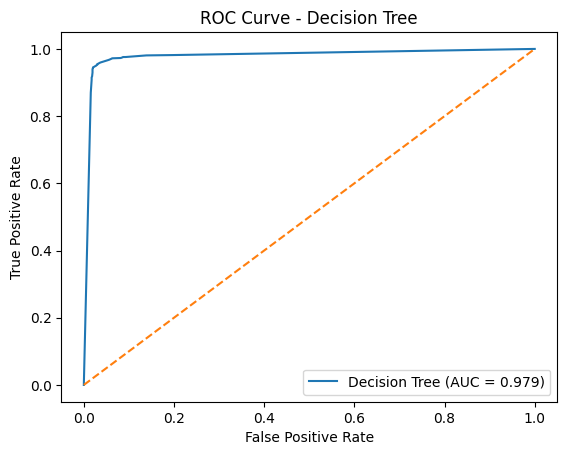

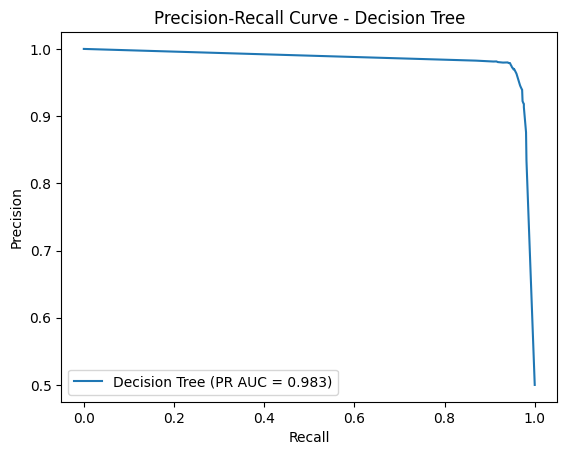

0.9623915139826422


In [ ]:
# Initialize the Decision Tree model with specified parameters.
#   - max_depth: Maximum depth of the tree to prevent overfitting. This parameter can be tuned.
#   - min_samples_split: Minimum number of samples required to split an internal node.
#   - min_samples_leaf: Minimum number of samples required to be at a leaf node.
#   - class_weight: 'balanced' adjusts weights inversely proportional to class frequencies to handle class imbalance.
#   - random_state: Controls the randomness of the estimator for reproducibility.

DT_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train the Decision Tree model using the training data
DT_model.fit(X_train, y_train)

# Evaluate the Decision Tree model using the custom helper function
dt_metrics = evaluate_model_with_plots(
    DT_model, X_test, y_test, name="Decision Tree"
)

# Calculate and print the accuracy score of the Decision Tree model on the test set
DT_accuracy = accuracy_score(y_test, DT_model.predict(X_test))
print(DT_accuracy)

### Random Forest


===== Random Forest === Grantz===
ROC-AUC: 0.9924
PR-AUC:  0.9927
Avg Precision (AP): 0.9927
Best threshold (by F1): 0.45
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1037
           1       0.95      0.97      0.96      1037

    accuracy                           0.96      2074
   macro avg       0.96      0.96      0.96      2074
weighted avg       0.96      0.96      0.96      2074

Confusion matrix (raw counts):
 [[ 988   49]
 [  29 1008]]


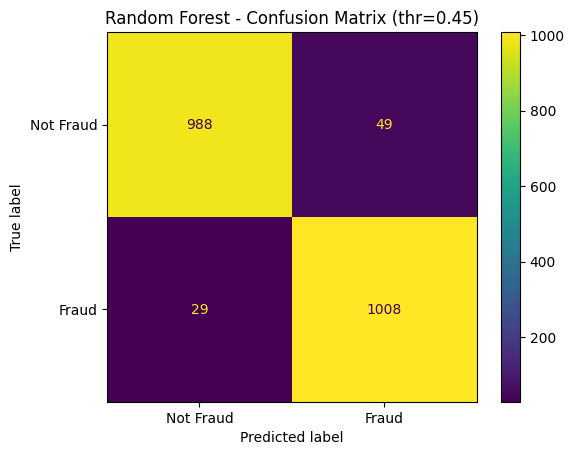

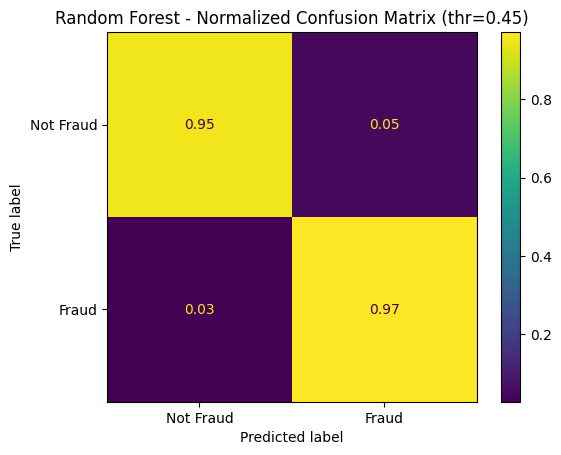

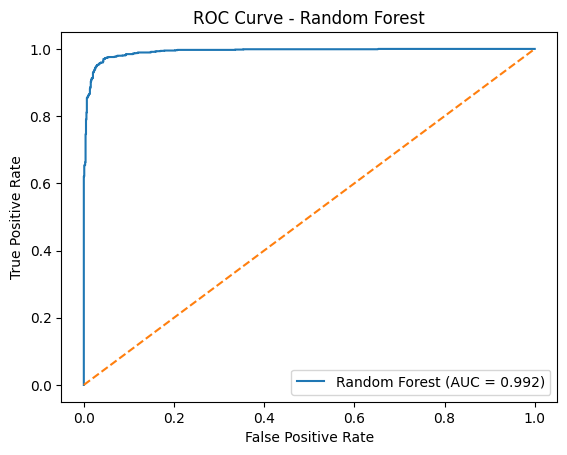

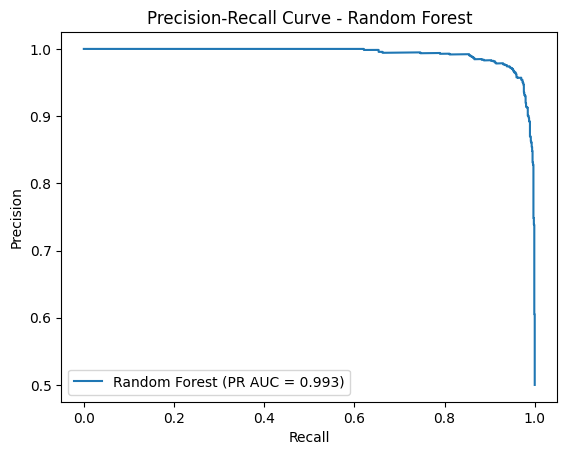

0.9604628736740598


In [ ]:
# Initialize the Random Forest model with specified parameters.
#   - n_estimators: The number of trees in the forest. More trees generally lead to better performance but longer training times.
#   - max_depth: The maximum depth of each tree. 'None' means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
#   - min_samples_split: The minimum number of samples required to split an internal node.
#   - min_samples_leaf: The minimum number of samples required to be at a leaf node.
#   - class_weight: 'balanced' adjusts weights inversely proportional to class frequencies to handle class imbalance.
#   - n_jobs: Number of CPU cores to use. -1 means using all available processors, which speeds up training.
#   - random_state: Controls the randomness of the estimator for reproducibility across runs.

RF_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Train the Random Forest model using the training data
RF_model.fit(X_train, y_train)

# Evaluate the Random Forest model using the custom helper function
rf_metrics = evaluate_model_with_plots(
    RF_model, X_test, y_test, name="Random Forest"
)

# Calculate and print the accuracy score of the Random Forest model on the test set
RF_accuracy = accuracy_score(y_test, RF_model.predict(X_test))
print(RF_accuracy)

## Genetic Algorithm (GA) Feature Selection

In [ ]:
# Step 1 – Install & import GA tools (DEAP)
# !pip install deap (re-run if needed)

In [ ]:
# Step 2 – Define RF evaluator settings
# Number of features (columns) in current X_train
n_features = X_train.shape[1]

# Random Forest model used as fitness evaluator
rf_evaluator = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Step 3 – Define the fitness function (uses RF + CV + F1)
def evaluate_individual(individual):
    """
    Evaluates a given individual (feature set) using a RandomForestClassifier
    and calculates its mean F1-score with stratified k-fold cross-validation.

    Args:
        individual: Binary list (0s/1s) representing selected features.

    Returns:
        Tuple containing the mean F1-score. Returns (0.0,) if no features are selected.
    """

    # Get indices of selected features
    selected_idx = [i for i, bit in enumerate(individual) if bit == 1]

    # Penalize individuals with no selected features
    if len(selected_idx) == 0:
        return 0.0,

    # Create a subset of training data with selected features
    X_sub = X_train[:, selected_idx]

    # Set up 3-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create an F1-score scorer
    f1_scorer = make_scorer(f1_score)

    # Perform cross-validation with the RF evaluator
    scores = cross_val_score(
        rf_evaluator,
        X_sub,
        y_train,
        cv=cv,
        scoring=f1_scorer,
        n_jobs=-1
    )

    # Return the mean F1-score (as a tuple for DEAP)
    return scores.mean(),

In [ ]:
# Step 4 – Set up the GA (DEAP toolbox)

# Define a "maximize" fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individual is just a list with that Fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Gene: 0 or 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Individual: n_features genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)

# Population: list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register operators
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# Step 5 – Run the Genetic Algorithm
pop_size = 20       # population size
n_gen = 5           # number of generations
cx_prob = 0.7       # crossover probability
mut_prob = 0.2      # mutation probability

# Initialize population
population = toolbox.population(n=pop_size)

print("Starting GA with RF evaluator...")
for gen in range(n_gen):
    print(f"\nGeneration {gen+1}/{n_gen}")

    # Evaluate all individuals
    for ind in population:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)

    # Show best fitness in this generation
    fits = [ind.fitness.values[0] for ind in population]
    print(f"  Best F1 in this generation: {max(fits):.4f}")
    print(f"  Avg F1 in this generation:  {np.mean(fits):.4f}")

    # Selection
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cx_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Mutation
    for mutant in offspring:
        if random.random() < mut_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate new individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)

    # Replace old population
    population[:] = offspring

print("\nGA finished.")

Starting GA with RF evaluator...

Generation 1/5
  Best F1 in this generation: 0.9661
  Avg F1 in this generation:  0.8639

Generation 2/5
  Best F1 in this generation: 0.9661
  Avg F1 in this generation:  0.9486

Generation 3/5
  Best F1 in this generation: 0.9661
  Avg F1 in this generation:  0.9639

Generation 4/5
  Best F1 in this generation: 0.9661
  Avg F1 in this generation:  0.9656

Generation 5/5
  Best F1 in this generation: 0.9661
  Avg F1 in this generation:  0.9566

GA finished.


In [ ]:
# Step 6 – Extract the best feature subset from GA

# Select the best individual (feature set) found by the Genetic Algorithm.
# `tools.selBest` selects the individual with the highest fitness value.
best_ind = tools.selBest(population, 1)[0]
# Retrieve the best F1-score achieved by this individual.
best_f1 = best_ind.fitness.values[0]

print("Best individual (0/1 mask) representing selected features:")
print(best_ind)
print("\nBest cross-validated F1 score (achieved by RF evaluator with this feature set):", best_f1)

# Determine the indices of the selected features.
# A '1' in the individual mask indicates that the feature at that index is selected.
selected_idx = [i for i, bit in enumerate(best_ind) if bit == 1]
print("\nNumber of selected features:", len(selected_idx))
print("Selected feature indices:", selected_idx)

# Create new training and testing datasets using only the features selected by the GA.
X_train_ga = X_train[:, selected_idx]
X_test_ga  = X_test[:, selected_idx]

Best individual (0/1 mask) representing selected features:
[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]

Best cross-validated F1 score (achieved by RF evaluator with this feature set): 0.966056246899328

Number of selected features: 9
Selected feature indices: [0, 1, 2, 4, 5, 6, 7, 11, 12]


## Machine Learning Models Training (Using GA selected features)

### Logistic Regression


===== GA-Selected Logistic Regression === Grantz===
ROC-AUC: 0.8433
PR-AUC:  0.8887
Avg Precision (AP): 0.8887
Best threshold (by F1): 0.60
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      1037
           1       0.95      0.74      0.83      1037

    accuracy                           0.85      2074
   macro avg       0.87      0.85      0.85      2074
weighted avg       0.87      0.85      0.85      2074

Confusion matrix (raw counts):
 [[994  43]
 [268 769]]


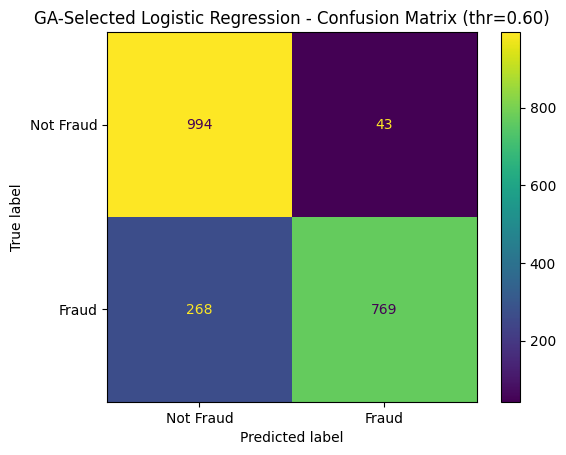

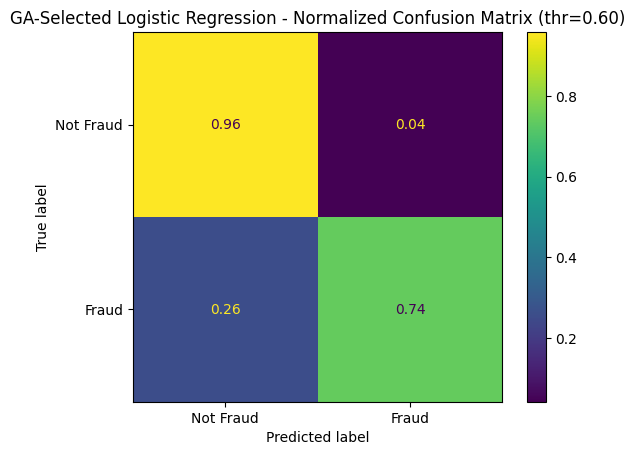

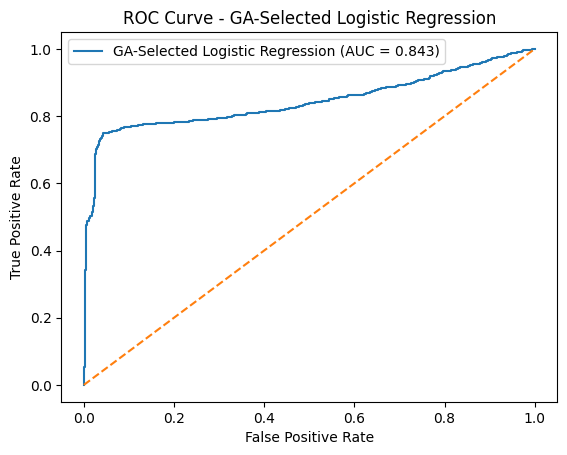

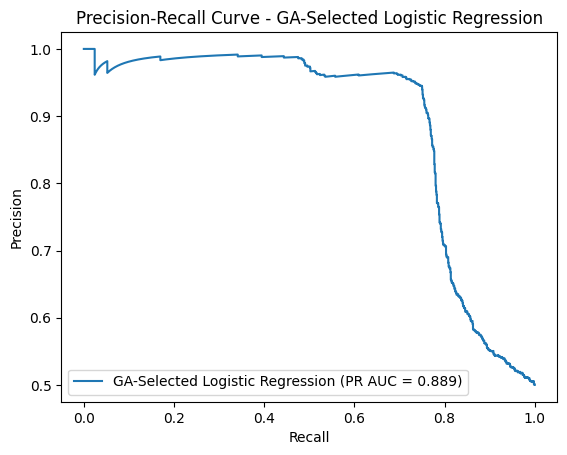

In [ ]:
# Logistic Regression with GA-selected features
LR_model_ga = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
LR_model_ga.fit(X_train_ga, y_train)

lr_ga_metrics = evaluate_model_with_plots(LR_model_ga, X_test_ga, y_test, name="GA-Selected Logistic Regression")

### Decision Tree


===== GA-Selected Decision Tree === Grantz===
ROC-AUC: 0.9844
PR-AUC:  0.9876
Avg Precision (AP): 0.9796
Best threshold (by F1): 0.50
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1037
           1       0.97      0.96      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[1008   29]
 [  39  998]]


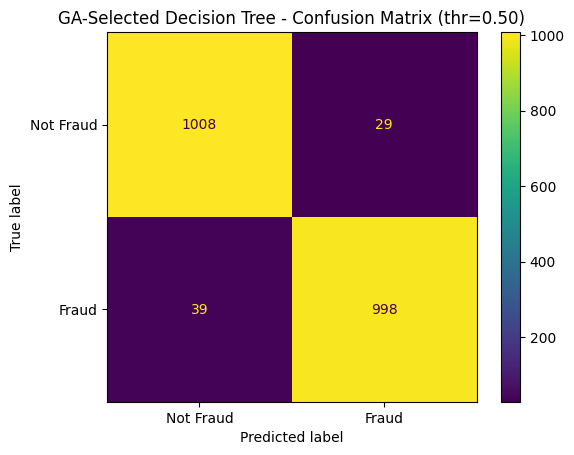

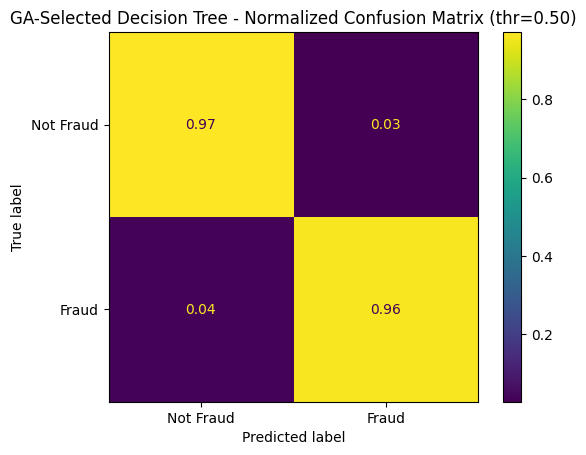

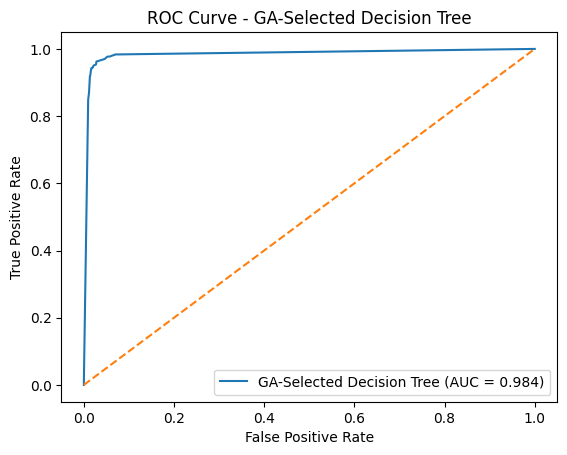

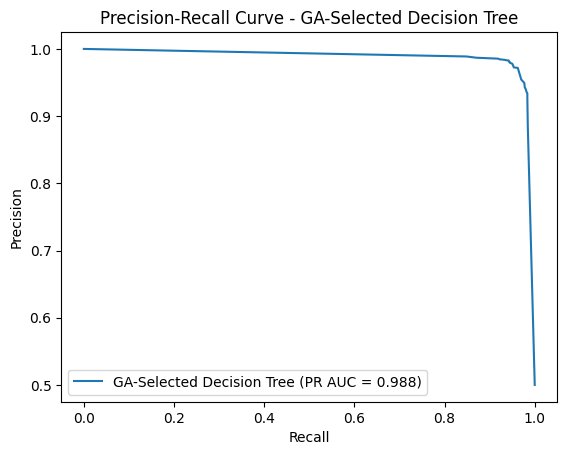

In [ ]:
# Decision Tree with GA-selected features
DT_model_ga = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
DT_model_ga.fit(X_train_ga, y_train)

dt_ga_metrics = evaluate_model_with_plots(DT_model_ga, X_test_ga, y_test, name="GA-Selected Decision Tree")

### Random Forest


===== GA-Selected Random Forest === Grantz===
ROC-AUC: 0.9947
PR-AUC:  0.9946
Avg Precision (AP): 0.9946
Best threshold (by F1): 0.55
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1037
           1       0.98      0.96      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[1017   20]
 [  43  994]]


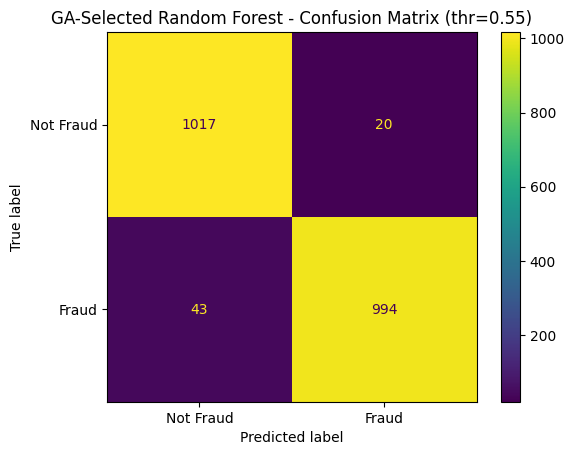

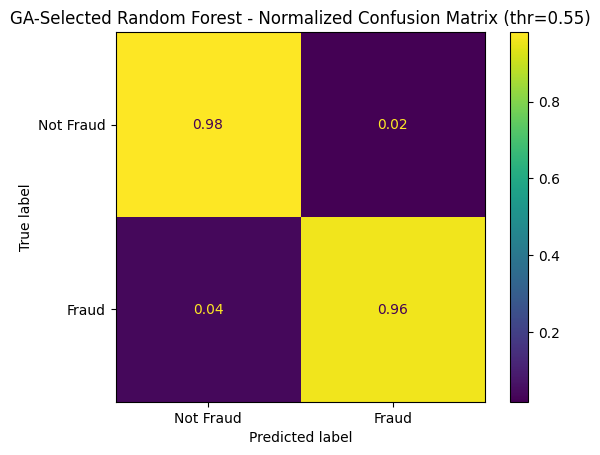

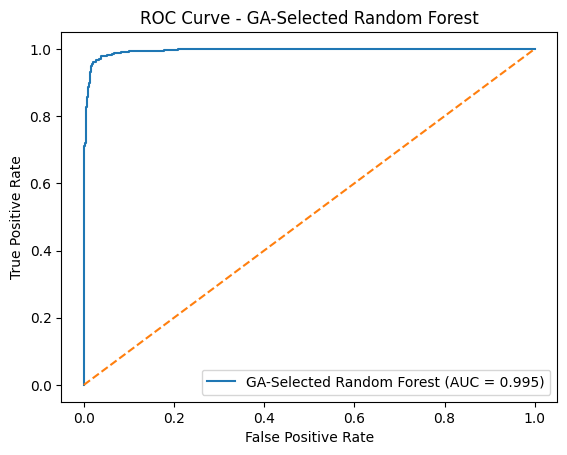

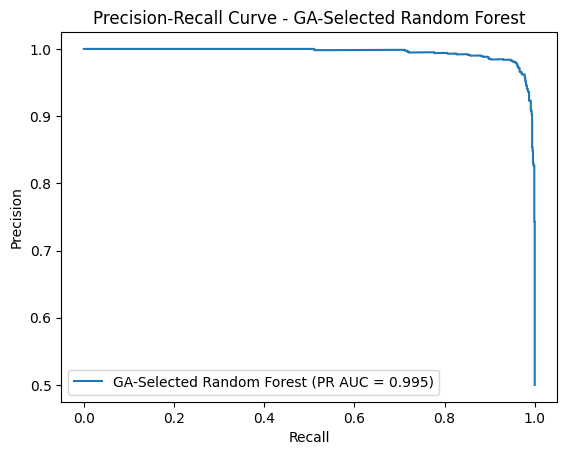

In [ ]:
# Random Forest with GA-selected features
RF_model_ga = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
RF_model_ga.fit(X_train_ga, y_train)

rf_ga_metrics = evaluate_model_with_plots(RF_model_ga, X_test_ga, y_test, name="GA-Selected Random Forest")

Analysis of the ML performances before GA vs after GA implementation

In [ ]:
def get_accuracy(model, X_test, y_test, threshold=None):
    """
    If threshold is given, use it to binarize probabilities.
    Otherwise, use model.predict().
    """
    if threshold is not None and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

rows = []

# ------------ Logistic Regression ------------
# Before GA
acc_lr_before = get_accuracy(LR_model, X_test, y_test, threshold=lr_metrics["best_threshold"])
rows.append({
    "Model": "LR",
    "Phase": "Before GA",
    "F1": lr_metrics["best_f1"],
    "ROC_AUC": lr_metrics["roc_auc"],
    "PR_AUC": lr_metrics["pr_auc"],
    "Accuracy": acc_lr_before
})

# After GA
acc_lr_after = get_accuracy(LR_model_ga, X_test_ga, y_test, threshold=lr_ga_metrics["best_threshold"])
rows.append({
    "Model": "LR",
    "Phase": "After GA",
    "F1": lr_ga_metrics["best_f1"],
    "ROC_AUC": lr_ga_metrics["roc_auc"],
    "PR_AUC": lr_ga_metrics["pr_auc"],
    "Accuracy": acc_lr_after
})

# ------------ Random Forest ------------
acc_rf_before = get_accuracy(RF_model, X_test, y_test, threshold=rf_metrics["best_threshold"])
rows.append({
    "Model": "RF",
    "Phase": "Before GA",
    "F1": rf_metrics["best_f1"],
    "ROC_AUC": rf_metrics["roc_auc"],
    "PR_AUC": rf_metrics["pr_auc"],
    "Accuracy": acc_rf_before
})

acc_rf_after = get_accuracy(RF_model_ga, X_test_ga, y_test, threshold=rf_ga_metrics["best_threshold"])
rows.append({
    "Model": "RF",
    "Phase": "After GA",
    "F1": rf_ga_metrics["best_f1"],
    "ROC_AUC": rf_ga_metrics["roc_auc"],
    "PR_AUC": rf_ga_metrics["pr_auc"],
    "Accuracy": acc_rf_after
})

# ------------ Decision Tree ------------
acc_dt_before = get_accuracy(DT_model, X_test, y_test, threshold=dt_metrics["best_threshold"])
rows.append({
    "Model": "DT",
    "Phase": "Before GA",
    "F1": dt_metrics["best_f1"],
    "ROC_AUC": dt_metrics["roc_auc"],
    "PR_AUC": dt_metrics["pr_auc"],
    "Accuracy": acc_dt_before
})

acc_dt_after = get_accuracy(DT_model_ga, X_test_ga, y_test, threshold=dt_ga_metrics["best_threshold"])
rows.append({
    "Model": "DT",
    "Phase": "After GA",
    "F1": dt_ga_metrics["best_f1"],
    "ROC_AUC": dt_ga_metrics["roc_auc"],
    "PR_AUC": dt_ga_metrics["pr_auc"],
    "Accuracy": acc_dt_after
})

results_df = pd.DataFrame(rows)
print(results_df)

  Model      Phase        F1   ROC_AUC    PR_AUC  Accuracy
0    LR  Before GA  0.833067  0.843305  0.888524  0.849084
1    LR   After GA  0.831801  0.843292  0.888664  0.850048
2    RF  Before GA  0.962751  0.992387  0.992655  0.962392
3    RF   After GA  0.969283  0.994720  0.994620  0.969624
4    DT  Before GA  0.961727  0.978930  0.982899  0.962392
5    DT   After GA  0.967054  0.984403  0.987590  0.967213


## 1st Novelty (Use F2-score as fitness)

In [ ]:
# ============================================================
# GA NOVELTY: Use F2-score (recall-focused) as fitness
# ============================================================

def evaluate_individual_f2(individual):
    """
    Evaluates a given individual (feature set) by training a RandomForestClassifier
    and calculating its mean F2-score (with beta=2) using stratified k-fold cross-validation.
    The F2-score places more emphasis on recall than precision, which is often desirable
    in fraud detection to minimize false negatives (missed frauds).

    Args:
        individual: A list of binary values (0s/1s) representing selected features.
                    Its length should be equal to the total number of features (n_features).

    Returns:
        A tuple containing the mean F2-score. Returns (0.0,) if no features are selected
        to penalize empty feature sets.
    """

    # Identify the indices of features selected by the current individual (where the bit is 1)
    selected_idx = [i for i, bit in enumerate(individual) if bit == 1]

    # If no features are selected, assign a fitness of 0.0 to strongly discourage such individuals.
    if len(selected_idx) == 0:
        return 0.0,

    # Create a subset of the training data (X_train) using only the selected features.
    X_sub = X_train[:, selected_idx]

    # Set up 3-fold stratified cross-validation.
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create an F2-score scorer. The 'beta=2' parameter emphasizes recall over precision.
    f2_scorer = make_scorer(fbeta_score, beta=2)

    # Perform cross-validation with the RandomForest evaluator, using the F2-score as the metric.
    scores = cross_val_score(
        rf_evaluator,
        X_sub,
        y_train,
        cv=cv,
        scoring=f2_scorer,
        n_jobs=-1
    )

    # Return the mean of the F2-scores obtained from the cross-validation folds as a tuple.
    return scores.mean(),

In [ ]:
# New toolbox for F2-based GA
toolbox_f2 = base.Toolbox()
toolbox_f2.register("attr_bool", random.randint, 0, 1)
toolbox_f2.register("individual", tools.initRepeat, creator.Individual, toolbox_f2.attr_bool, n_features)
toolbox_f2.register("population", tools.initRepeat, list, toolbox_f2.individual)

toolbox_f2.register("evaluate", evaluate_individual_f2)
toolbox_f2.register("mate", tools.cxTwoPoint)
toolbox_f2.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_f2.register("select", tools.selTournament, tournsize=3)

In [ ]:
# GA hyperparameters for F2-based GA
pop_size_f2 = 20
n_gen_f2 = 5
cx_prob_f2 = 0.7
mut_prob_f2 = 0.2

# Initialize population
population_f2 = toolbox_f2.population(n=pop_size_f2)

print("Starting GA with RF evaluator and F2-score fitness...")
for gen in range(n_gen_f2):
    print(f"\n[F2 GA] Generation {gen+1}/{n_gen_f2}")

    # Evaluate all individuals
    for ind in population_f2:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox_f2.evaluate(ind)

    # Show best fitness in this generation
    fits = [ind.fitness.values[0] for ind in population_f2]
    print(f"  Best F2 in this generation: {max(fits):.4f}")
    print(f"  Avg  F2 in this generation: {np.mean(fits):.4f}")

    # Selection
    offspring = toolbox_f2.select(population_f2, len(population_f2))
    offspring = list(map(toolbox_f2.clone, offspring))

    # Crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cx_prob_f2:
            toolbox_f2.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Mutation
    for mutant in offspring:
        if random.random() < mut_prob_f2:
            toolbox_f2.mutate(mutant)
            del mutant.fitness.values

    # Evaluate new individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox_f2.evaluate(ind)

    # Replace old population
    population_f2[:] = offspring

print("\nF2-based GA finished.")

Starting GA with RF evaluator and F2-score fitness...

[F2 GA] Generation 1/5
  Best F2 in this generation: 0.9659
  Avg  F2 in this generation: 0.8491

[F2 GA] Generation 2/5
  Best F2 in this generation: 0.9692
  Avg  F2 in this generation: 0.9422

[F2 GA] Generation 3/5
  Best F2 in this generation: 0.9692
  Avg  F2 in this generation: 0.9582

[F2 GA] Generation 4/5
  Best F2 in this generation: 0.9692
  Avg  F2 in this generation: 0.9636

[F2 GA] Generation 5/5
  Best F2 in this generation: 0.9692
  Avg  F2 in this generation: 0.9666

F2-based GA finished.


In [ ]:
# Best individual found by F2-GA
best_ind_f2 = tools.selBest(population_f2, 1)[0]
best_f2_fitness = best_ind_f2.fitness.values[0]

print("Best individual (0/1 mask) - F2 GA:")
print(best_ind_f2)
print("\nBest cross-validated F2 (RF evaluator):", best_f2_fitness)

# Indices of selected features (F2 GA)
selected_idx_f2 = [i for i, bit in enumerate(best_ind_f2) if bit == 1]
print("\nNumber of selected features (F2 GA):", len(selected_idx_f2))
print("Selected feature indices (F2 GA):", selected_idx_f2)

# Build GA-F2 feature sets
X_train_ga_f2 = X_train[:, selected_idx_f2]
X_test_ga_f2  = X_test[:, selected_idx_f2]

Best individual (0/1 mask) - F2 GA:
[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]

Best cross-validated F2 (RF evaluator): 0.9740982424412162

Number of selected features (F2 GA): 4
Selected feature indices (F2 GA): [1, 2, 4, 11]


### Random Forest Model Training (Using F2-Score as fitness)


===== GA-F2 Selected Random Forest === Grantz===
ROC-AUC: 0.9959
PR-AUC:  0.9958
Avg Precision (AP): 0.9958
Best threshold (by F1): 0.45
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1037
           1       0.96      0.98      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[ 996   41]
 [  21 1016]]


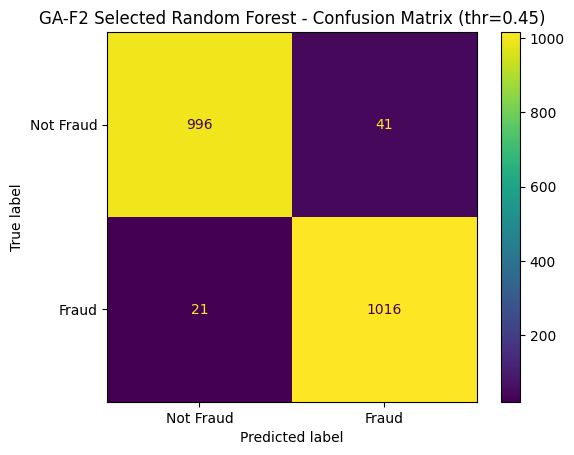

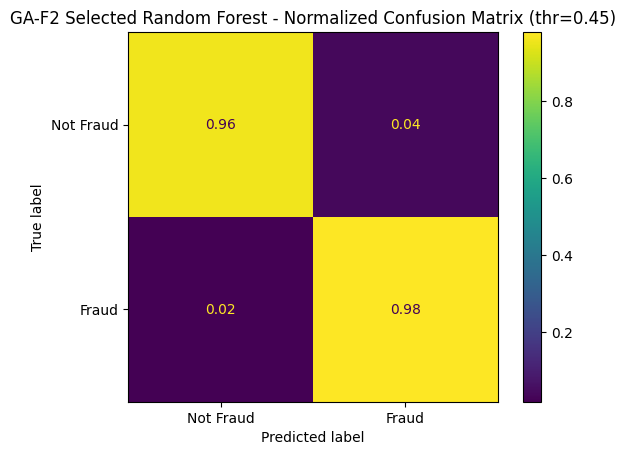

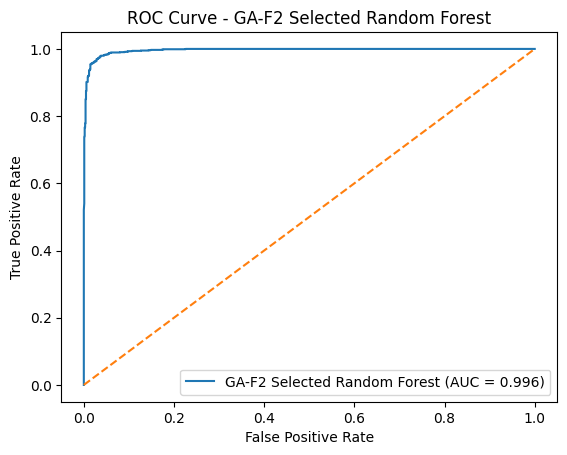

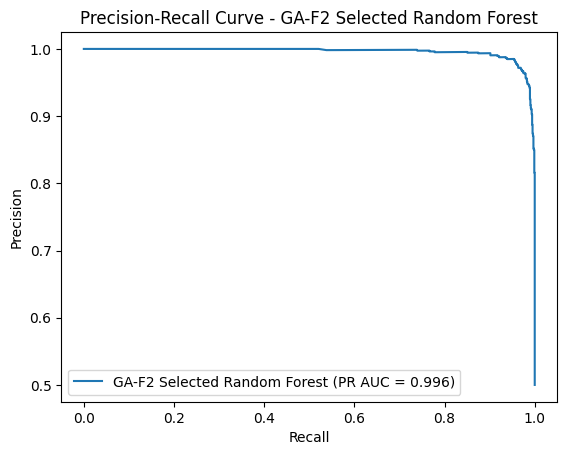

In [ ]:
# Random Forest with GA-F2-selected features
RF_model_ga_f2 = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

RF_model_ga_f2.fit(X_train_ga_f2, y_train)

rf_ga_f2_metrics = evaluate_model_with_plots(RF_model_ga_f2, X_test_ga_f2, y_test, name="GA-F2 Selected Random Forest")

## 2nd Novelty (Use CatBoost as fitness evaluator replacing Random Forest)

In [ ]:
# CatBoost model used as fitness evaluator for GA

cat_evaluator = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="F1",
    verbose=0,
    random_seed=42
)

def evaluate_individual_cat(individual):
    """
    GA fitness function that evaluates an individual (feature subset) using a CatBoostClassifier.
    The fitness is determined by the mean F1-score obtained through 3-fold stratified cross-validation.

    Args:
        individual: A list of 0s and 1s representing the selection of features.
                    A '1' indicates the feature is selected, '0' means it's not.

    Returns:
        Tuple containing the mean F1-score from cross-validation. Returns (0.0,) if no features are selected.
    """
    # Extract indices of selected features (where the bit is 1)
    selected_idx = [i for i, bit in enumerate(individual) if bit == 1]

    # If no features are selected, return a fitness of 0.0 to penalize such individuals.
    if len(selected_idx) == 0:
        return 0.0,

    # Create a subset of the training data using only the selected features.
    X_sub = X_train[:, selected_idx]

    # Set up 3-fold stratified cross-validation.
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Define the F1-score as the metric for evaluating the model.
    f1_scorer = make_scorer(f1_score)

    # Perform cross-validation to get an unbiased estimate of the F1-score.
    scores = cross_val_score(
        cat_evaluator,
        X_sub,
        y_train,
        cv=cv,
        scoring=f1_scorer,
        n_jobs=-1
    )

    # Return the mean F1-score as a tuple.
    return scores.mean(),

In [ ]:
# New toolbox for CatBoost-based GA
toolbox_cat = base.Toolbox()
toolbox_cat.register("attr_bool", random.randint, 0, 1)
toolbox_cat.register("individual", tools.initRepeat, creator.Individual, toolbox_cat.attr_bool, n_features)
toolbox_cat.register("population", tools.initRepeat, list, toolbox_cat.individual)

toolbox_cat.register("evaluate", evaluate_individual_cat)
toolbox_cat.register("mate", tools.cxTwoPoint)
toolbox_cat.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_cat.register("select", tools.selTournament, tournsize=3)

In [ ]:
# GA hyperparameters for CatBoost-based GA
pop_size_cat = 20
n_gen_cat = 5
cx_prob_cat = 0.7
mut_prob_cat = 0.2

# Initialize population: Create the first generation of individuals randomly.
population_cat = toolbox_cat.population(n=pop_size_cat)

print("Starting GA with CatBoost evaluator (F1 fitness)...")
for gen in range(n_gen_cat):
    print(f"\n[GA-CB] Generation {gen+1}/{n_gen_cat}")

    # Evaluate all individuals in the current population.
    for ind in population_cat:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox_cat.evaluate(ind)

    # Show best and average fitness in this generation for monitoring progress.
    fits = [ind.fitness.values[0] for ind in population_cat]
    print(f"  Best F1 (CatBoost) this gen: {max(fits):.4f}")
    print(f"  Avg  F1 (CatBoost) this gen: {np.mean(fits):.4f}")

    # Selection: Select the next generation's parents from the current population.
    offspring = toolbox_cat.select(population_cat, len(population_cat))
    # Create deep copies of the selected individuals to allow for modification without affecting parents.
    offspring = list(map(toolbox_cat.clone, offspring))

    # Crossover: Apply crossover to pairs of offspring.
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        # Perform crossover if a random number is less than the crossover probability.
        if random.random() < cx_prob_cat:
            toolbox_cat.mate(child1, child2)
            # Invalidate the fitness of the children as they have changed.
            del child1.fitness.values
            del child2.fitness.values

    # Mutation: Apply mutation to each offspring.
    for mutant in offspring:
        # Perform mutation if a random number is less than the mutation probability.
        if random.random() < mut_prob_cat:
            toolbox_cat.mutate(mutant)
            # Invalidate the fitness of the mutant as it has changed.
            del mutant.fitness.values

    # Evaluate new individuals: Evaluate the fitness of the modified offspring.
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox_cat.evaluate(ind)

    # Replace population: The offspring become the new population for the next generation.
    population_cat[:] = offspring

print("\nCatBoost-based GA finished.")

Starting GA with CatBoost evaluator (F1 fitness)...

[GA-CB] Generation 1/5
  Best F1 (CatBoost) this gen: 0.9732
  Avg  F1 (CatBoost) this gen: 0.7829

[GA-CB] Generation 2/5
  Best F1 (CatBoost) this gen: 0.9732
  Avg  F1 (CatBoost) this gen: 0.9182

[GA-CB] Generation 3/5
  Best F1 (CatBoost) this gen: 0.9743
  Avg  F1 (CatBoost) this gen: 0.9600

[GA-CB] Generation 4/5
  Best F1 (CatBoost) this gen: 0.9743
  Avg  F1 (CatBoost) this gen: 0.9734

[GA-CB] Generation 5/5
  Best F1 (CatBoost) this gen: 0.9743
  Avg  F1 (CatBoost) this gen: 0.9641

CatBoost-based GA finished.


In [ ]:
# Select the individual with the highest fitness (F1-score) from the final population.
best_ind_cat = tools.selBest(population_cat, 1)[0]
# Retrieve the best cross-validated F1 score achieved by this individual.
best_cat_f1 = best_ind_cat.fitness.values[0]

print("Best individual (0/1 mask) - CatBoost GA:")
print(best_ind_cat)
print("\nBest cross-validated F1 (CatBoost evaluator):", best_cat_f1)

# Indices of selected features: extract the positions where the gene is '1'.
selected_idx_cat = [i for i, bit in enumerate(best_ind_cat) if bit == 1]
print("\nNumber of selected features (CatBoost GA):", len(selected_idx_cat))
print("Selected feature indices (CatBoost GA):", selected_idx_cat)

# Create new X_train and X_test datasets using only the features identified by the CatBoost-based GA.
X_train_ga_cat = X_train[:, selected_idx_cat]
X_test_ga_cat  = X_test[:, selected_idx_cat]

Best individual (0/1 mask) - CatBoost GA:
[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]

Best cross-validated F1 (CatBoost evaluator): 0.974320295880259

Number of selected features (CatBoost GA): 8
Selected feature indices (CatBoost GA): [1, 2, 3, 4, 7, 8, 10, 11]



===== GA-CatBoost (F1 fitness) === Grantz===
ROC-AUC: 0.9963
PR-AUC:  0.9959
Avg Precision (AP): 0.9959
Best threshold (by F1): 0.45
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1037
           1       0.97      0.98      0.98      1037

    accuracy                           0.98      2074
   macro avg       0.98      0.98      0.98      2074
weighted avg       0.98      0.98      0.98      2074

Confusion matrix (raw counts):
 [[1004   33]
 [  17 1020]]


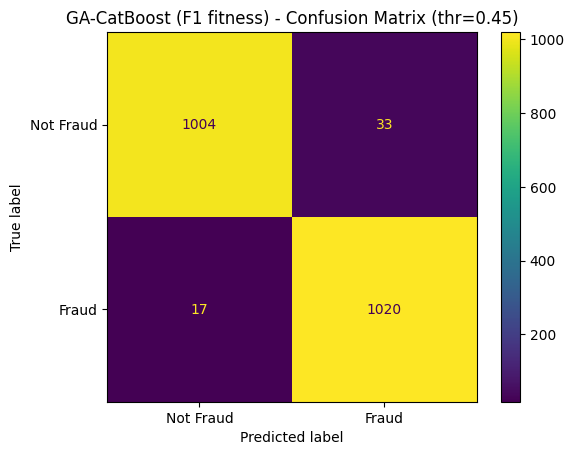

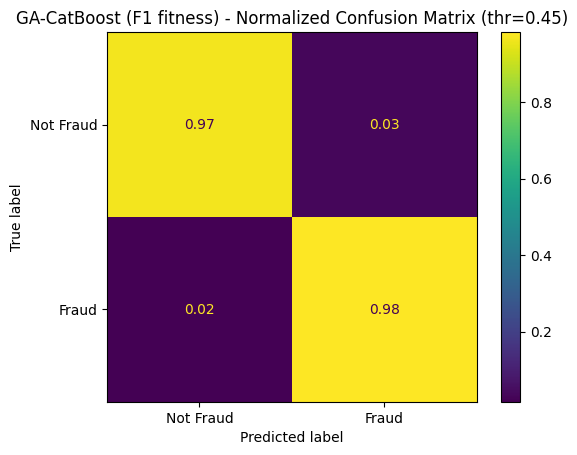

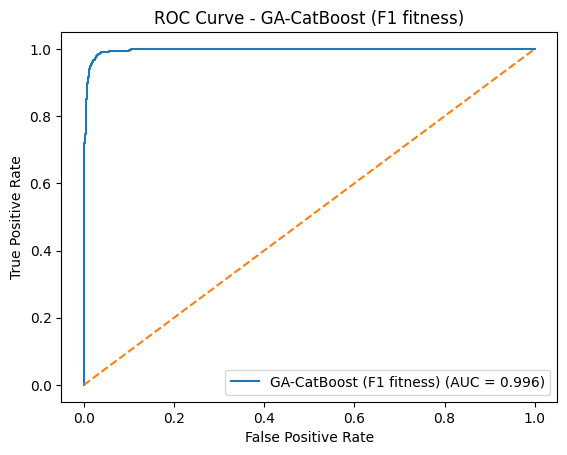

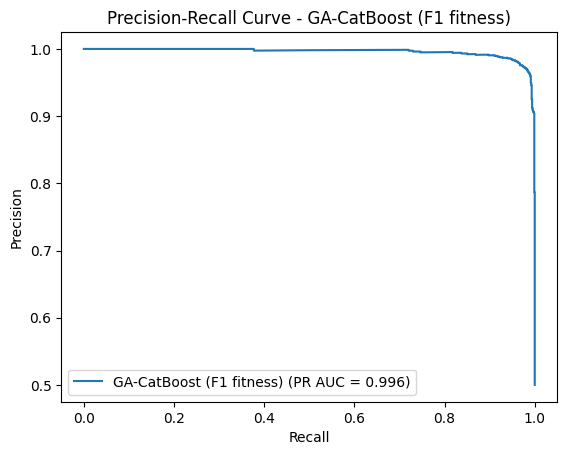

In [ ]:
# Final CatBoost model trained on GA-CB-selected features
cat_final = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="F1",
    verbose=0,
    random_seed=42
)

cat_final.fit(X_train_ga_cat, y_train)

cat_ga_metrics = evaluate_model_with_plots(cat_final, X_test_ga_cat, y_test, name="GA-CatBoost (F1 fitness)")

In [ ]:
comparison_all = pd.DataFrame([
    {
        "Model": "GA-F1 RF",
        "F1": rf_ga_metrics["best_f1"],
        "ROC_AUC": rf_ga_metrics["roc_auc"],
        "PR_AUC": rf_ga_metrics["pr_auc"],
        "Best_Thr": rf_ga_metrics["best_threshold"]
    },
    {
        "Model": "GA-F2 RF",
        "F1": rf_ga_f2_metrics["best_f1"],
        "ROC_AUC": rf_ga_f2_metrics["roc_auc"],
        "PR_AUC": rf_ga_f2_metrics["pr_auc"],
        "Best_Thr": rf_ga_f2_metrics["best_threshold"]
    },
    {
        "Model": "GA-CatBoost",
        "F1": cat_ga_metrics["best_f1"],
        "ROC_AUC": cat_ga_metrics["roc_auc"],
        "PR_AUC": cat_ga_metrics["pr_auc"],
        "Best_Thr": cat_ga_metrics["best_threshold"]
    }
])

# Display the DataFrame comparing the performance metrics of the different GA-selected models.
# This table provides a summary of F1-score, ROC-AUC, PR-AUC, and the best threshold for each model.
print(comparison_all)

         Model        F1   ROC_AUC    PR_AUC  Best_Thr
0     GA-F1 RF  0.969283  0.994720  0.994620      0.55
1     GA-F2 RF  0.970392  0.995923  0.995833      0.45
2  GA-CatBoost  0.976077  0.996260  0.995862      0.45


### Machine Learning Models Training (Using GA-CatBoost selected features)

Logistic Regression


===== LR with GA-CatBoost Features === Grantz===
ROC-AUC: 0.8359
PR-AUC:  0.8839
Avg Precision (AP): 0.8840
Best threshold (by F1): 0.60
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1037
           1       0.95      0.75      0.84      1037

    accuracy                           0.85      2074
   macro avg       0.87      0.85      0.85      2074
weighted avg       0.87      0.85      0.85      2074

Confusion matrix (raw counts):
 [[997  40]
 [263 774]]


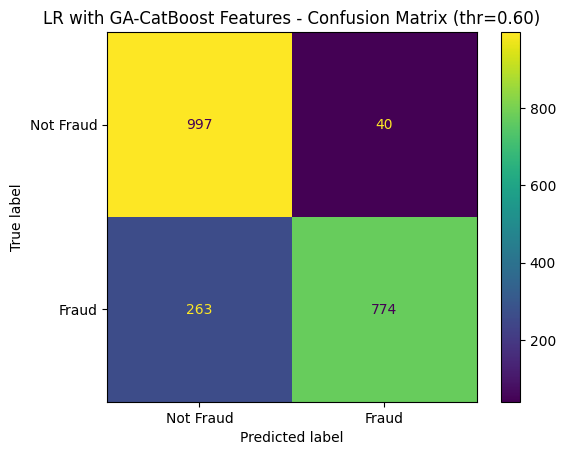

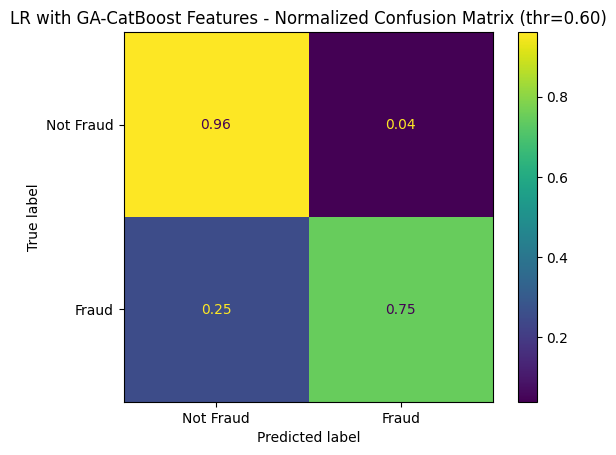

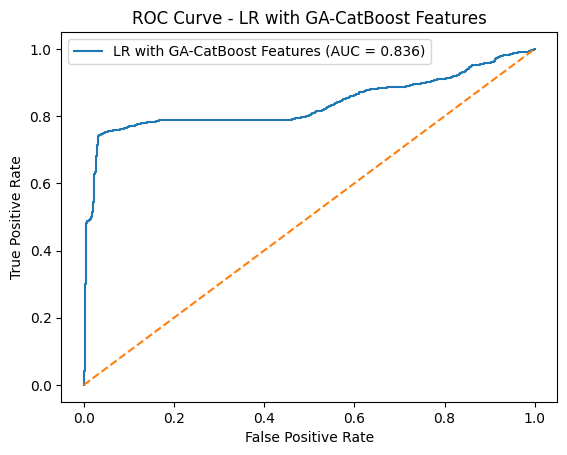

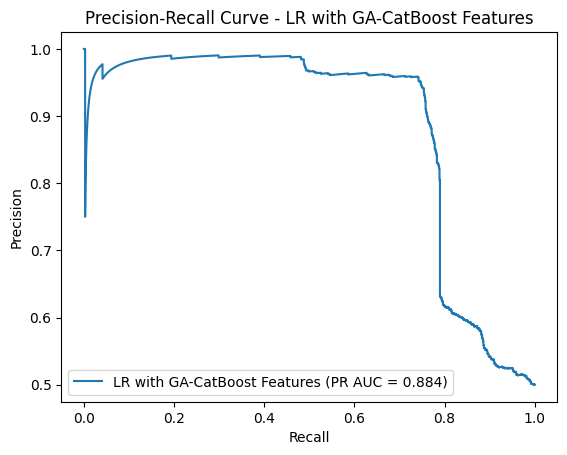

In [ ]:
# Logistic Regression on GA-CB features
LR_model_ga_cb = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

LR_model_ga_cb.fit(X_train_ga_cat, y_train)

lr_ga_cb_metrics = evaluate_model_with_plots(LR_model_ga_cb, X_test_ga_cat, y_test, name="LR with GA-CatBoost Features")

Decision Tree


===== DT with GA-CatBoost Features === Grantz===
ROC-AUC: 0.9819
PR-AUC:  0.9846
Avg Precision (AP): 0.9737
Best threshold (by F1): 0.70
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1037
           1       0.98      0.96      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[1012   25]
 [  43  994]]


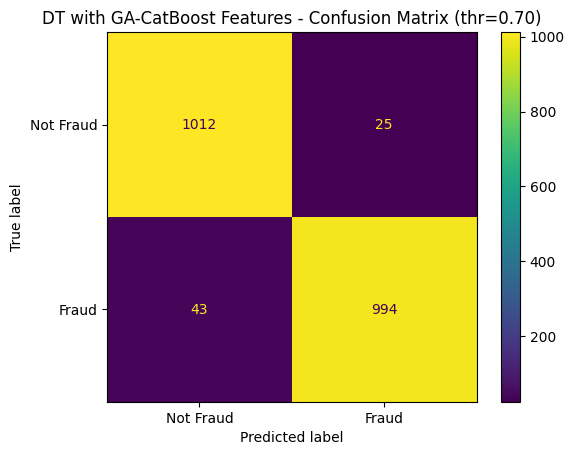

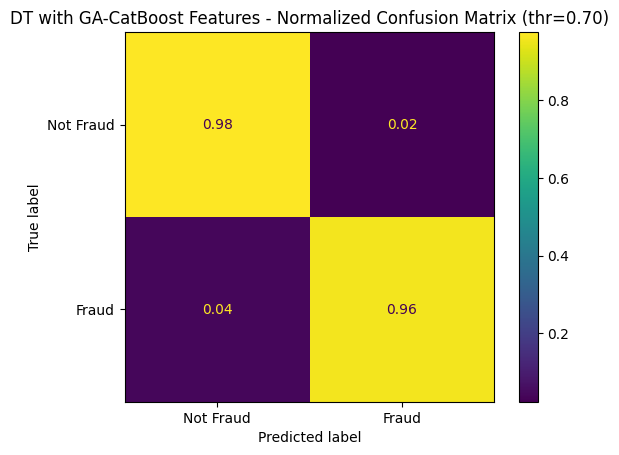

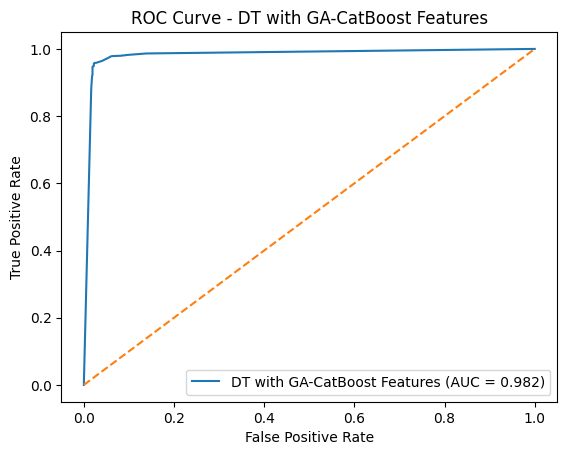

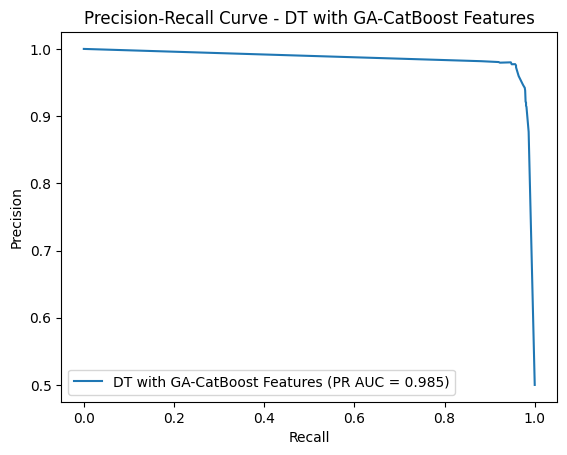

In [ ]:
# Decision Tree on GA-CB features
DT_model_ga_cb = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

DT_model_ga_cb.fit(X_train_ga_cat, y_train)

dt_ga_cb_metrics = evaluate_model_with_plots(DT_model_ga_cb, X_test_ga_cat, y_test, name="DT with GA-CatBoost Features")

Random Forest


===== RF with GA-CatBoost Features === Grantz===
ROC-AUC: 0.9932
PR-AUC:  0.9934
Avg Precision (AP): 0.9934
Best threshold (by F1): 0.45
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1037
           1       0.96      0.97      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[ 998   39]
 [  31 1006]]


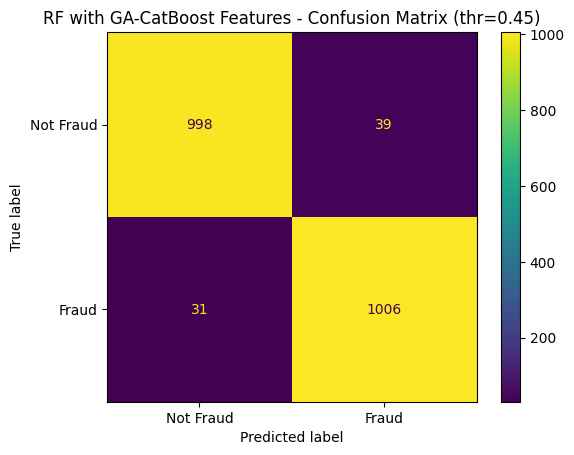

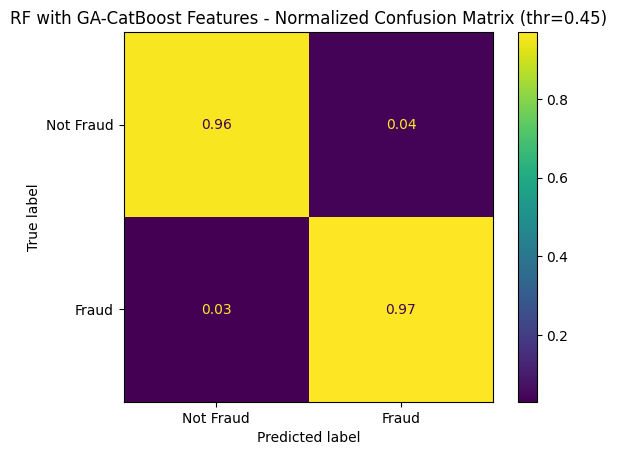

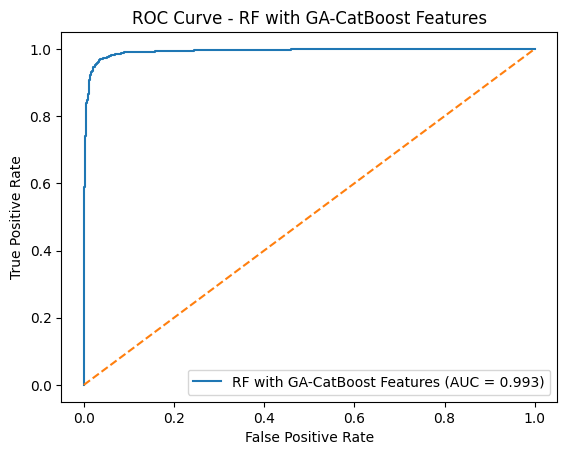

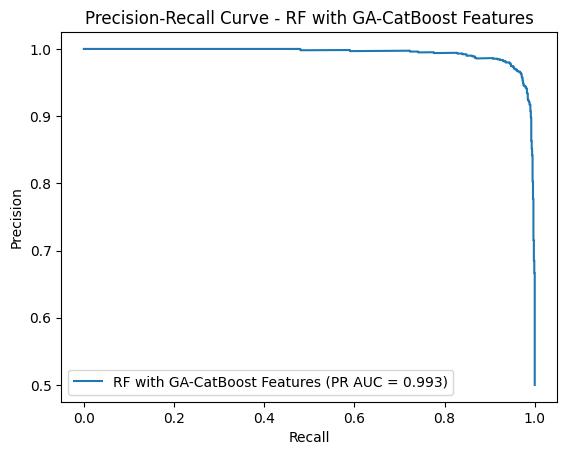

In [ ]:
# Random Forest on GA-CB features
RF_model_ga_cb = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

RF_model_ga_cb.fit(X_train_ga_cat, y_train)

rf_ga_cb_metrics = evaluate_model_with_plots(RF_model_ga_cb, X_test_ga_cat, y_test, name="RF with GA-CatBoost Features")

Analysis of

In [ ]:
# Helper function to safely add a row to the results list if the metrics dictionary exists.
# This prevents errors if a particular model's metrics were not generated.
def add_result(rows, name, phase, metrics_dict):
    if metrics_dict is None:
        return
    rows.append({
        "Model": name,
        "Phase": phase,
        "F1": float(metrics_dict.get("best_f1", float("nan"))),
        "ROC_AUC": float(metrics_dict.get("roc_auc", float("nan"))),
        "PR_AUC": float(metrics_dict.get("pr_auc", float("nan"))),
        "Best_Thr": float(metrics_dict.get("best_threshold", float("nan"))),
    })

rows = [] # Initialize an empty list to store all results

# ------------------------------------------------------------------------
# Collect metrics for Baseline Models (before Genetic Algorithm feature selection)
# ------------------------------------------------------------------------
add_result(rows, "LR", "Baseline", globals().get("lr_metrics"))
add_result(rows, "DT", "Baseline", globals().get("dt_metrics"))
add_result(rows, "RF", "Baseline", globals().get("rf_metrics"))

# ------------------------------------------------------------------------
# Collect metrics for Models trained with features selected by GA (F1 fitness with RF evaluator)
# ------------------------------------------------------------------------
add_result(rows, "LR", "GA-F1 RF Features", globals().get("lr_ga_metrics"))
add_result(rows, "DT", "GA-F1 RF Features", globals().get("dt_ga_metrics"))
add_result(rows, "RF", "GA-F1 RF Features", globals().get("rf_ga_metrics"))

# ------------------------------------------------------------------------
# Collect metrics for RF Model trained with features selected by GA (F2 fitness with RF evaluator)
# F2-score focuses more on recall, important for fraud detection to minimize false negatives.
# ------------------------------------------------------------------------
add_result(rows, "RF", "GA-F2 RF Features", globals().get("rf_ga_f2_metrics"))

# ------------------------------------------------------------------------
# Collect metrics for Models trained with features selected by GA (F1 fitness with CatBoost evaluator)
# This represents the second novelty where CatBoost is used for feature selection.
# ------------------------------------------------------------------------
add_result(rows, "LR", "GA-CatBoost Features", globals().get("lr_ga_cb_metrics"))
add_result(rows, "DT", "GA-CatBoost Features", globals().get("dt_ga_cb_metrics"))
add_result(rows, "RF", "GA-CatBoost Features", globals().get("rf_ga_cb_metrics"))

# ------------------------------------------------------------------------
# Include the final CatBoost model's performance itself (trained on its GA-selected features)
# ------------------------------------------------------------------------
add_result(rows, "CatBoost", "GA-CatBoost Final Model", globals().get("cat_ga_metrics"))

# Build DataFrame: Convert the list of dictionaries into a pandas DataFrame for structured display.
results_all = pd.DataFrame(rows)

# Nice ordering: Reorder columns for better readability and presentation.
results_all = results_all[["Model", "Phase", "F1", "ROC_AUC", "PR_AUC", "Best_Thr"]]

# Print the comprehensive comparison table.
print(results_all)

# Optional: sort for readability to easily compare models or phases.
print("\nSorted by Model then Phase:")
print(results_all.sort_values(by=["Model", "Phase"]))

       Model                    Phase        F1   ROC_AUC    PR_AUC  Best_Thr
0         LR                 Baseline  0.833067  0.843305  0.888524      0.55
1         DT                 Baseline  0.961727  0.978930  0.982899      0.85
2         RF                 Baseline  0.962751  0.992387  0.992655      0.45
3         LR        GA-F1 RF Features  0.831801  0.843292  0.888664      0.60
4         DT        GA-F1 RF Features  0.967054  0.984403  0.987590      0.50
5         RF        GA-F1 RF Features  0.969283  0.994720  0.994620      0.55
6         RF        GA-F2 RF Features  0.970392  0.995923  0.995833      0.45
7         LR     GA-CatBoost Features  0.836305  0.835881  0.883867      0.60
8         DT     GA-CatBoost Features  0.966926  0.981907  0.984557      0.70
9         RF     GA-CatBoost Features  0.966378  0.993242  0.993411      0.45
10  CatBoost  GA-CatBoost Final Model  0.976077  0.996260  0.995862      0.45

Sorted by Model then Phase:
       Model                    Pha